In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt

from plotting import *
from data_processing import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)


# Sociohydrodynamics model


$$ \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j  - \Gamma_i \phi_i \big(1 - \sum_j \phi_j \big) \nabla^3 \phi_i \bigg) $$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B + c^3_{ij} \phi_A^2 + c^4_{ij} \phi_B^2 + c^5_{ij} \phi_A \phi_B $$

## Load data

(80, 80) (100, 99)
[-2082.29 -2080.6  -2078.91 -2077.22 -2075.53]
[-186.26 -184.55 -182.84 -181.14 -179.43]
(100, 99) 5468


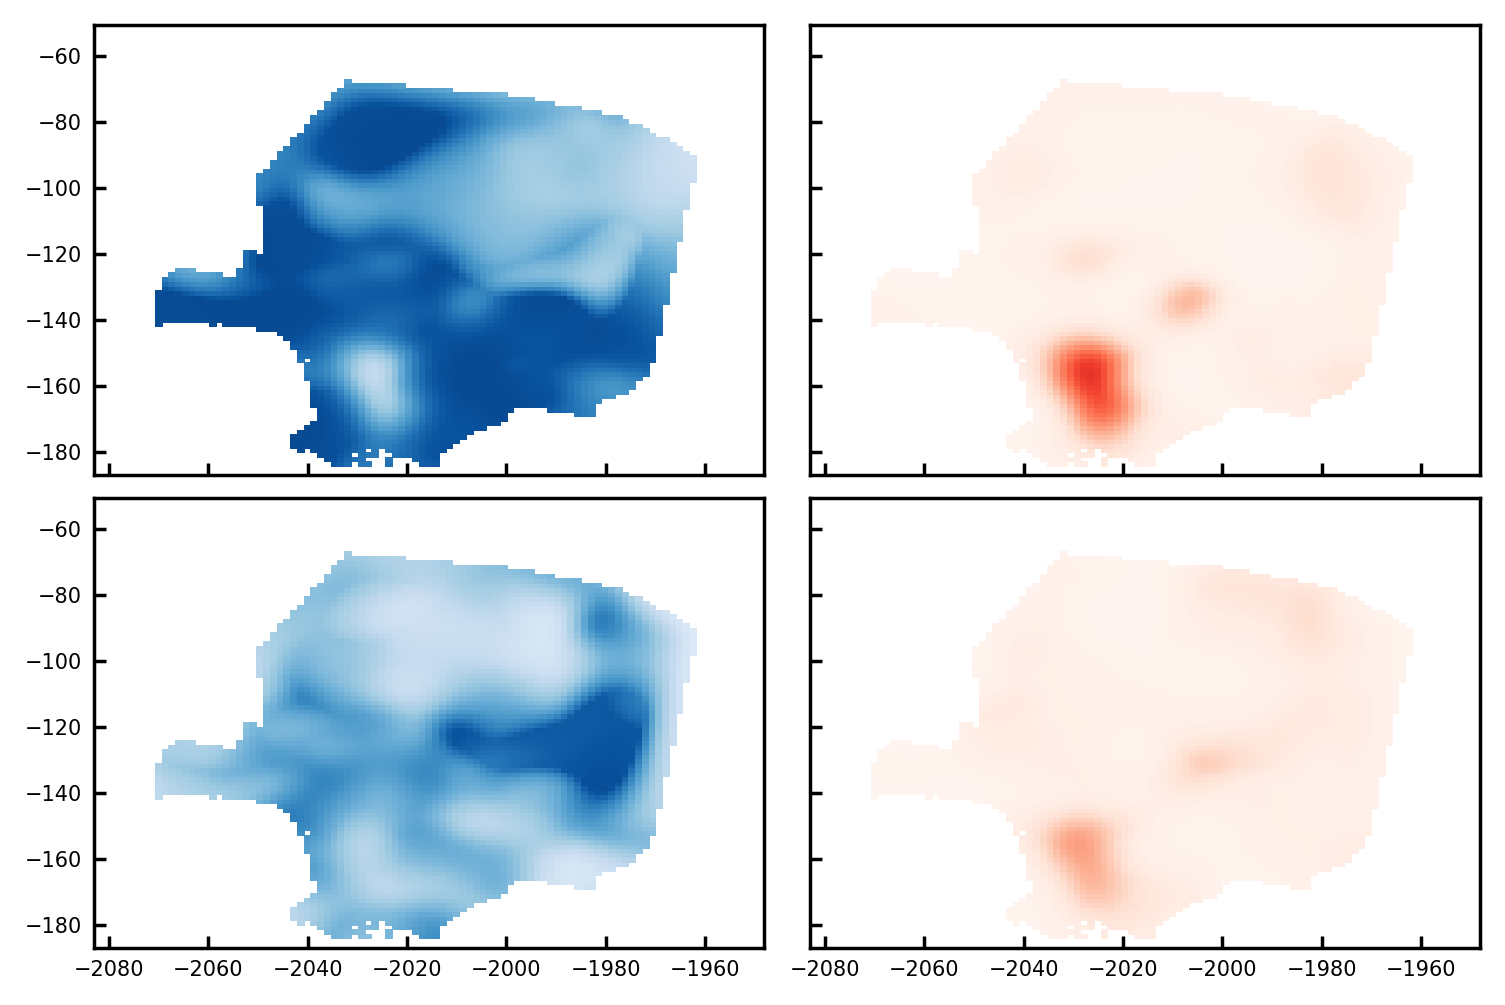

In [14]:
from scipy.interpolate import griddata

'''
Load and plot data from HDF5 files 
'''

county = 'la_CA'

with h5py.File(f"data/{county}.hdf5", "r") as d:
    x_grid = d["x_grid"][:] / 1e3
    y_grid = d["y_grid"][:] / 1e3
    w_grid = d["w_grid_array_masked"][:].transpose(2, 0, 1)
    b_grid = d["b_grid_array_masked"][:].transpose(2, 0, 1)
    
    Ny = 80
    Nx = int(Ny * x_grid.shape[0] / x_grid.shape[1])
    
    X_grid, Y_grid = np.meshgrid(
        np.linspace(x_grid.min(), x_grid.max(), Nx),
        np.linspace(y_grid.min(), y_grid.max(), Ny),
        indexing='xy')
    
    print(X_grid.shape, y_grid.shape)
    print(X_grid[0, :5])
    print(Y_grid[:5, 0])
    
    W_grid, B_grid = [], []
    
    mask = np.any(np.logical_or(np.isnan(w_grid), np.isnan(b_grid)), axis=0)

    for ii in range(w_grid.shape[0]):
        W_grid.append(smooth_with_fill(w_grid[ii], sigma=3))
        B_grid.append(smooth_with_fill(b_grid[ii], sigma=3))

    
    #y_grid, x_grid = Y_grid, X_grid
    w_grid = np.stack(W_grid)
    b_grid = np.stack(B_grid)
    
    #Convert to occupation fraction
    max_grid = (w_grid + b_grid).max(axis=0) * 1.1
    w_grid /= max_grid
    b_grid /= max_grid
    
    
mask = np.any(np.logical_or(np.isnan(w_grid), np.isnan(b_grid)), axis=0)
print(mask.shape, np.sum(mask))
                
T = np.array([1980, 1990, 2000, 2010, 2020])
kwargs = dict(x_grid=x_grid, y_grid=y_grid, wmax=8000, bmax=5000, smax=5, max_grid=max_grid)

fig, ax = plt.subplots(2, 2, sharey=True, sharex=True)

ax[0,0].pcolormesh(x_grid, y_grid, w_grid[0], cmap='Blues', vmax=1, vmin=0)
ax[0,1].pcolormesh(x_grid, y_grid, b_grid[0], cmap='Reds', vmax=1, vmin=0)
ax[1,0].pcolormesh(x_grid, y_grid, w_grid[4], cmap='Blues', vmax=1, vmin=0)
ax[1,1].pcolormesh(x_grid, y_grid, b_grid[4], cmap='Reds', vmax=1, vmin=0)

plt.tight_layout()

(274, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

Mesh has 4951 vertices


Text(0.5, 1.0, 'Black population')

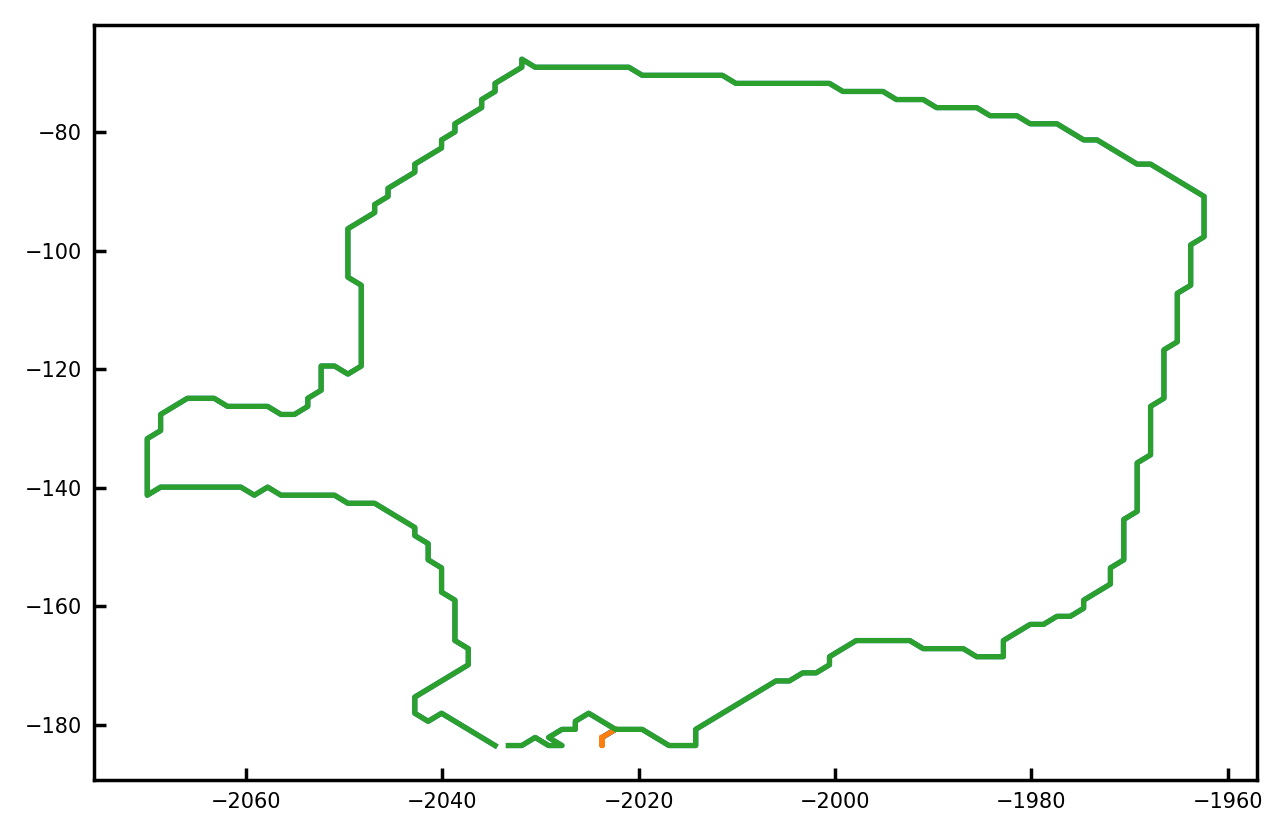

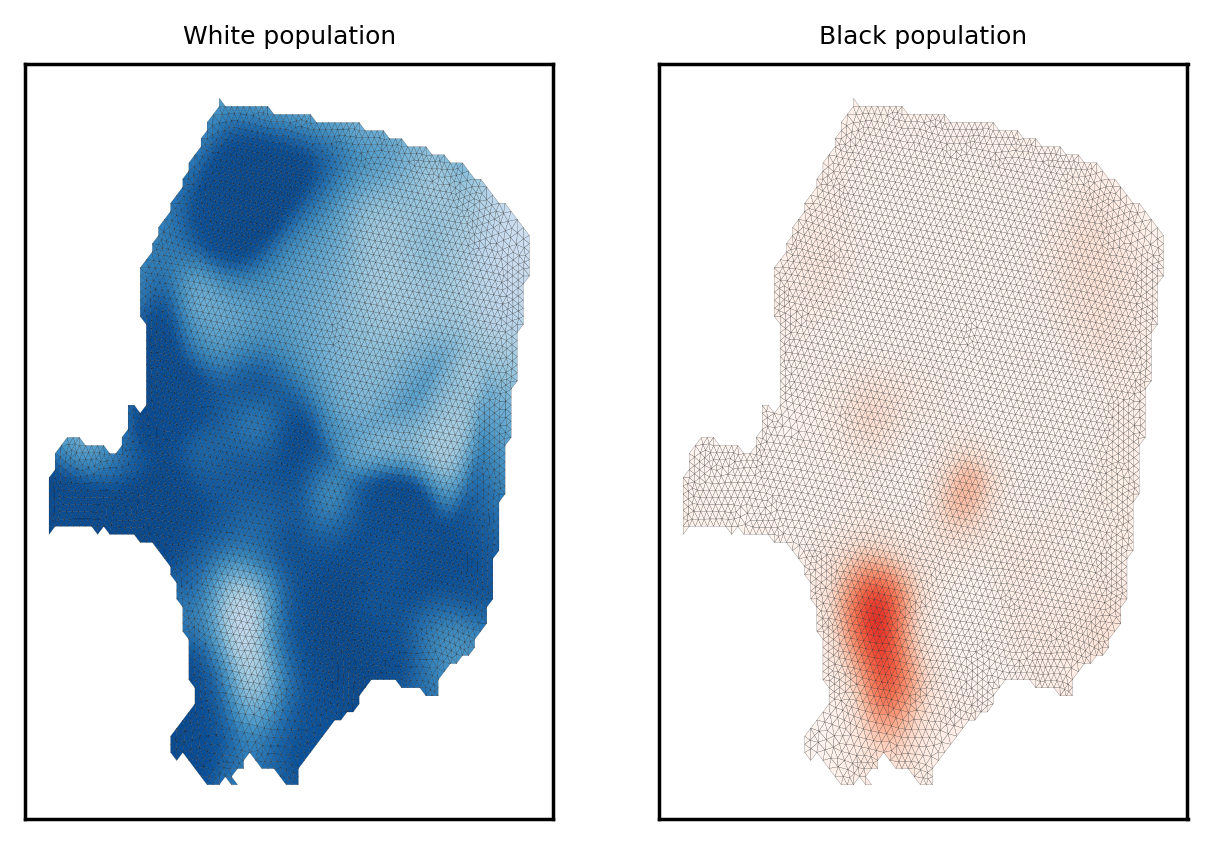

In [18]:
import pygmsh
import cv2

mask_float = np.zeros(mask.shape, dtype=np.uint8)
mask_float[~mask] = 255
contours, _ = cv2.findContours(mask_float, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

'''
countours is a list of lists -- you can change the index below here to get 
    different contours to choose as the mesh.
'''
idx = np.argmax([contours[i].squeeze().shape[0] for i in range(len(contours))])
polygon = contours[idx].squeeze()
print(polygon.shape)
pos_x = x_grid[polygon[:, 1], polygon[:, 0]]
pos_y = y_grid[polygon[:, 1], polygon[:, 0]]

plt.plot(pos_x, pos_y)
plt.plot(pos_x[259:263], pos_y[259:263])
pos_x = np.concatenate([pos_x[:259], pos_x[263:]], axis=0)
pos_y = np.concatenate([pos_y[:259], pos_y[263:]], axis=0)
plt.plot(pos_x, pos_y)

with pygmsh.geo.Geometry() as geom:
    geom.add_polygon(np.stack([pos_x, pos_y], axis=-1), mesh_size=2)
    mesh = geom.generate_mesh(dim=2, verbose=True)
mesh.points = mesh.points[:, :2]
mesh.write(f'data/{county}_mesh.xml')

from fenics import Mesh
mesh = Mesh(f'data/{county}_mesh.xml')
print(f'Mesh has {mesh.coordinates().shape[0]} vertices')


from fenics import dof_to_vertex_map, vertex_to_dof_map, Function, project, interpolate
verts = mesh.coordinates()
w_verts = griddata((y_grid[~mask], x_grid[~mask]), w_grid[0, ~mask], (verts[:, 1], verts[:, 0]))
b_verts = griddata((y_grid[~mask], x_grid[~mask]), b_grid[0, ~mask], (verts[:, 1], verts[:, 0]))
mx_verts = griddata((y_grid[~mask], x_grid[~mask]), max_grid[~mask], (verts[:, 1], verts[:, 0]))


def plot_mesh(ax, f, lw=False, scale=1, vmin=0, vmax=1, **kwargs):
    x, y = mesh.coordinates()[:, 0], mesh.coordinates()[:, 1]
    tri = mesh.cells()
    if lw:
        kwargs['edgecolors'] = 'black'
        kwargs['linewidth'] = 0.05
    if not isinstance(f, np.ndarray):
        ax.tripcolor(x, y, f.compute_vertex_values() * scale, triangles=tri, vmin=vmin, vmax=vmax, **kwargs)
    else:
        ax.tripcolor(x, y, f * scale, triangles=tri, vmin=vmin, vmax=vmax, **kwargs)
    ax.set(xticks=[], yticks=[])

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
plot_mesh(ax[0], w_verts, cmap='Blues', lw=True)
ax[0].set_title('White population')
plot_mesh(ax[1], b_verts, cmap='Reds',lw=True)
ax[1].set_title('Black population')

## Simple diffusion model for testing

$$ \dot{\phi}_i = \nabla \cdot (D_{ij} \nabla \phi_j) $$

Setting up variational problem
Starting to integrate


  0%|          | 0/40 [00:00<?, ?it/s]

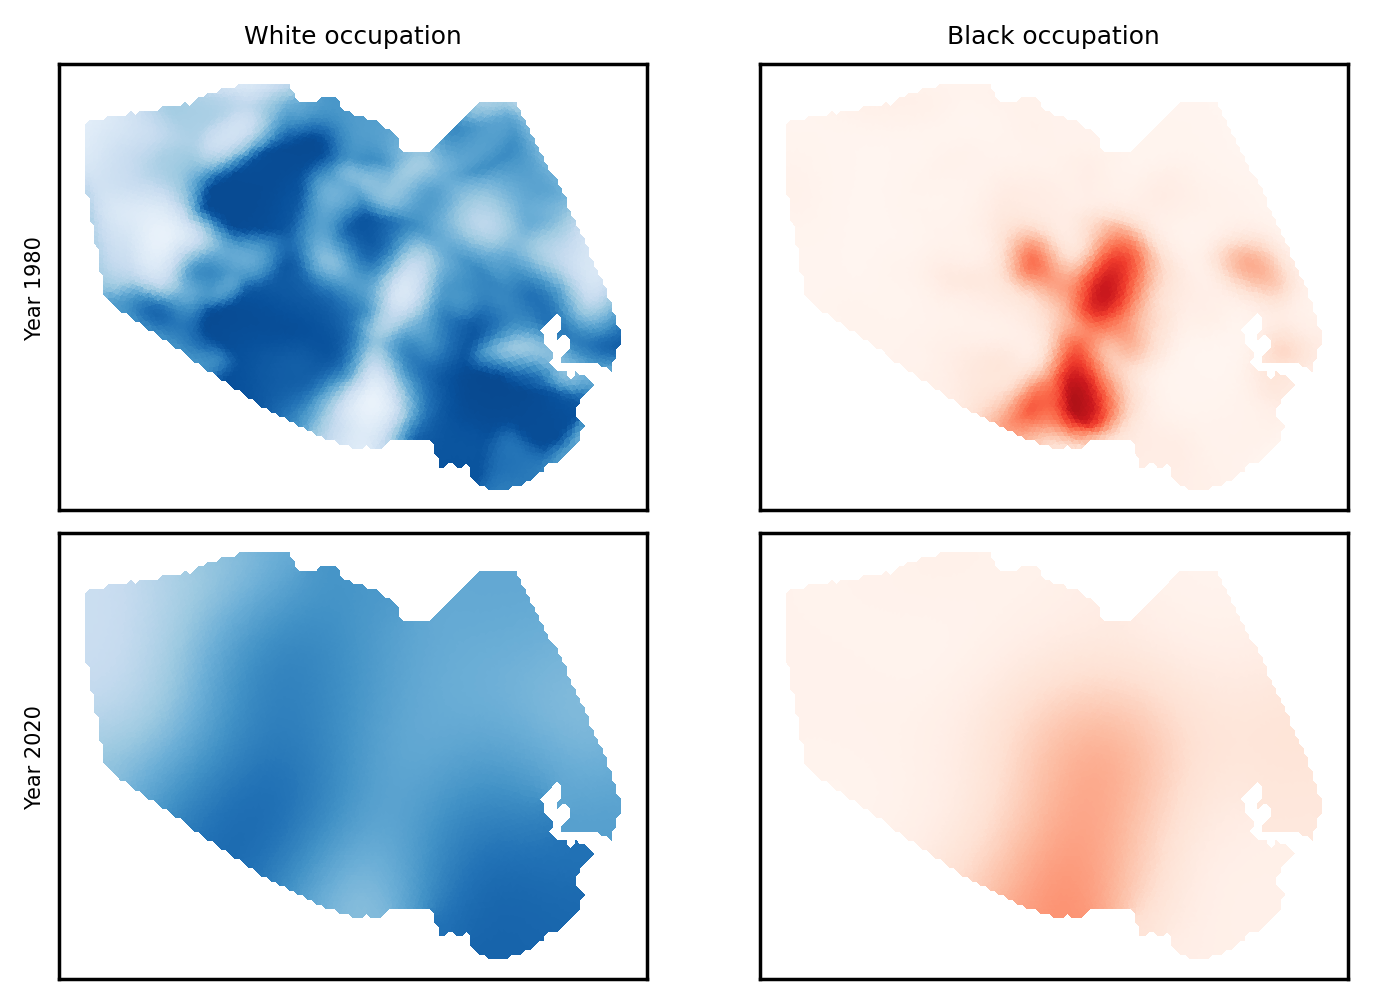

In [4]:
from time import time
from scipy.interpolate import griddata
from matplotlib.cm import get_cmap
from fenics import plot as plot_fenics
from fenics import FiniteElement, FunctionSpace, DirichletBC, Constant
from fenics import TrialFunctions, TestFunctions, solve
from fenics import dot, grad, dx

v = FiniteElement('Lagrange', mesh.ufl_cell(), 1)
vv = v * v
V = FunctionSpace(mesh, v)
VV = FunctionSpace(mesh, vv)

d2v = dof_to_vertex_map(V)
v2d = vertex_to_dof_map(V)

w0 = Function(V)
w0.vector().set_local(w_verts[d2v])
b0 = Function(V)
b0.vector().set_local(b_verts[d2v])

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
plot_mesh(ax[0, 0], w0, cmap='Blues')
plot_mesh(ax[0, 1], b0, cmap='Reds')

ax[0,0].set_title('White occupation')
ax[0,1].set_title('Black occupation')
ax[0,0].set_ylabel('Year 1980')


print('Setting up variational problem')
dt = 1
w, b = TrialFunctions(VV)
u, v = TestFunctions(VV)

Dww = 1
Dwb = 0.1
Dbw = 0.1
Dbb = 1

a = w*u*dx + b*v*dx
a += dt * dot(Dww * grad(w), grad(u)) * dx
a += dt * dot(Dwb * grad(b), grad(u)) * dx
a += dt * dot(Dbw * grad(w), grad(v)) * dx
a += dt * dot(Dbb * grad(b), grad(v)) * dx

L = w0*u*dx + b0*v*dx

wb = Function(VV)

print('Starting to integrate')
t = 1980
tmax = 2020
with tqdm(total=(tmax-t)//dt) as pbar:
    while t < tmax:
        solve(a == L, wb)
        wi, bi = wb.split(True)
        w0.assign(wi)
        b0.assign(bi)
        t += dt
        pbar.update()

plot_mesh(ax[1, 0], w0, cmap='Blues')
plot_mesh(ax[1, 1], b0, cmap='Reds')
ax[1,0].set_ylabel(f'Year {tmax}')
    
for a in ax.flatten():
    a.set_aspect('equal')
plt.tight_layout()

## Diffusion with a spatially-dependent diffusion field

Setting up variational problem
Starting to integrate


  0%|          | 0/40 [00:00<?, ?it/s]

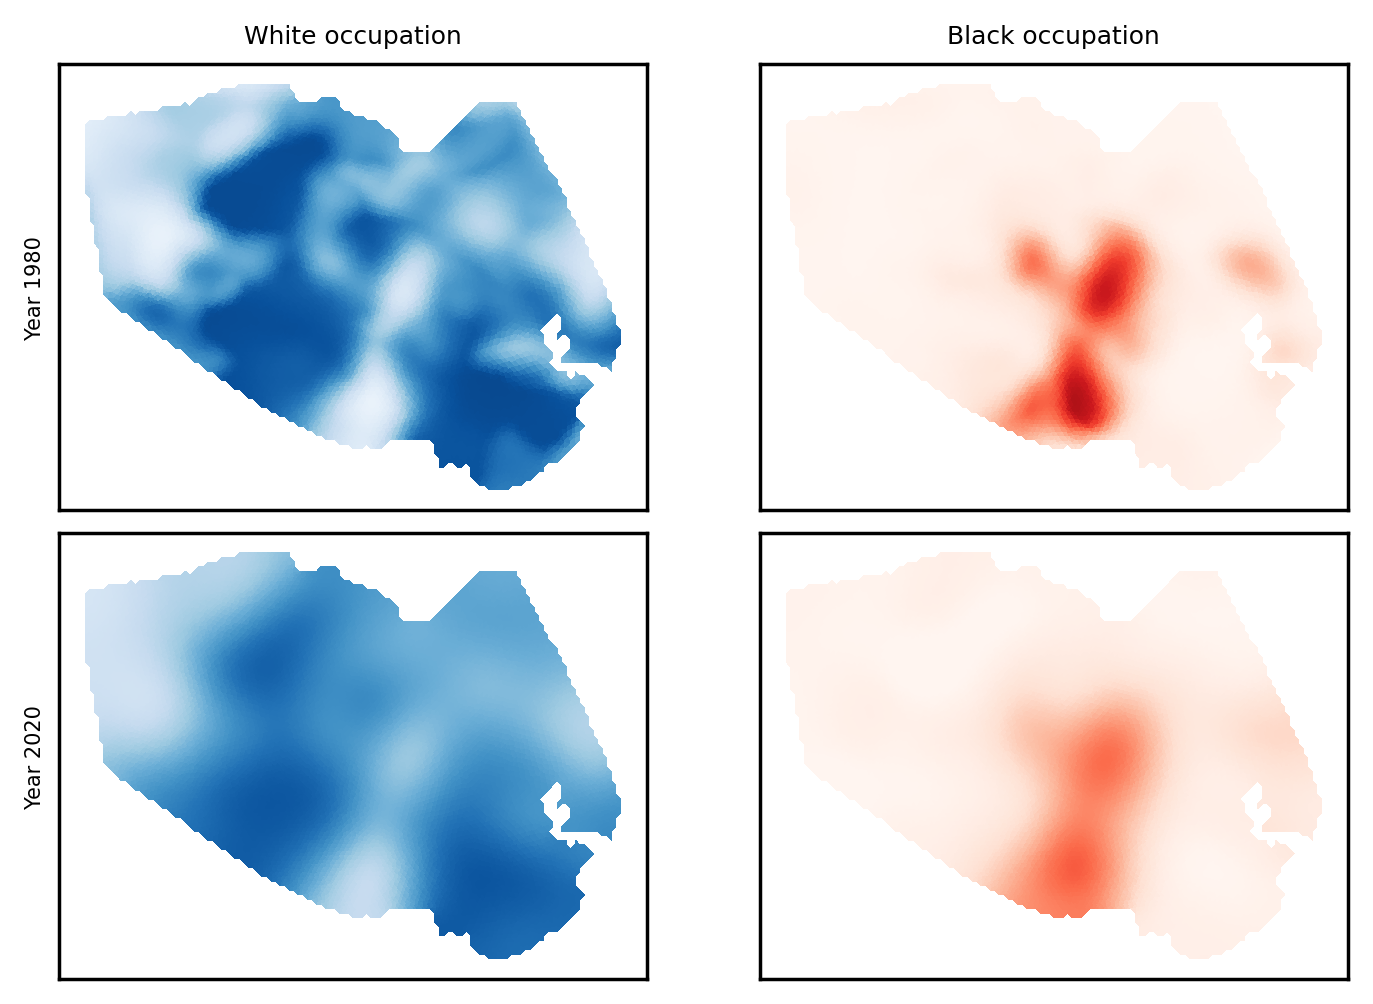

In [5]:
from time import time
from scipy.interpolate import griddata
from matplotlib.cm import get_cmap
from fenics import plot as plot_fenics
from fenics import FiniteElement, FunctionSpace, DirichletBC, Constant
from fenics import TrialFunctions, TestFunctions, solve
from fenics import dot, grad, dx

v = FiniteElement('Lagrange', mesh.ufl_cell(), 1)
vv = v * v
V = FunctionSpace(mesh, v)
VV = FunctionSpace(mesh, vv)

d2v = dof_to_vertex_map(V)
v2d = vertex_to_dof_map(V)

w0 = Function(V)
w0.vector().set_local(w_verts[d2v])
b0 = Function(V)
b0.vector().set_local(b_verts[d2v])

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
plot_mesh(ax[0, 0], w0, cmap='Blues')
plot_mesh(ax[0, 1], b0, cmap='Reds')

ax[0,0].set_title('White occupation')
ax[0,1].set_title('Black occupation')
ax[0,0].set_ylabel('Year 1980')


print('Setting up variational problem')
dt = 1
w, b = TrialFunctions(VV)
u, v = TestFunctions(VV)

N = V.dim()
Dww = Function(V)
Dww.vector()[:] = 0.25 + 0.05 * np.random.random(size=N)
Dwb = Function(V)
Dwb.vector()[:] = 0.05 + 0.05 * np.random.random(size=N)
Dbw = Function(V)
Dbw.vector()[:] = 0.05 + 0.05 * np.random.random(size=N)
Dbb = Function(V)
Dbb.vector()[:] = 0.25 + 0.05 * np.random.random(size=N)

a = w*u*dx + b*v*dx
a += dt * dot(Dww * grad(w), grad(u)) * dx
a += dt * dot(Dwb * grad(b), grad(u)) * dx
a += dt * dot(Dbw * grad(w), grad(v)) * dx
a += dt * dot(Dbb * grad(b), grad(v)) * dx

L = w0*u*dx + b0*v*dx

wb = Function(VV)

print('Starting to integrate')
t = 1980
tmax = 2020
with tqdm(total=(tmax-t)//dt) as pbar:
    while t < tmax:
        solve(a == L, wb)
        wi, bi = wb.split(True)
        w0.assign(wi)
        b0.assign(bi)
        t += dt
        pbar.update()

plot_mesh(ax[1, 0], w0, cmap='Blues')
plot_mesh(ax[1, 1], b0, cmap='Reds')
ax[1,0].set_ylabel(f'Year {t}')
    
for a in ax.flatten():
    a.set_aspect('equal')
plt.tight_layout()

## Diffusion with a source and gamma term

In [ ]:
from time import time
from scipy.interpolate import griddata
from matplotlib.cm import get_cmap
from fenics import plot as plot_fenics
from fenics import FiniteElement, FunctionSpace, DirichletBC, Constant
from fenics import TrialFunctions, TestFunctions, solve
from fenics import dot, grad, div, dx

v = FiniteElement('Lagrange', mesh.ufl_cell(), 1)
vv = v * v
V = FunctionSpace(mesh, v)
VV = FunctionSpace(mesh, vv)

d2v = dof_to_vertex_map(V)
v2d = vertex_to_dof_map(V)

w0 = Function(V)
w0.vector().set_local(w_verts[d2v])
b0 = Function(V)
b0.vector().set_local(b_verts[d2v])

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
plot_mesh(ax[0, 0], w0, cmap='Blues')
plot_mesh(ax[0, 1], b0, cmap='Reds')

ax[0,0].set_title('White occupation')
ax[0,1].set_title('Black occupation')
ax[0,0].set_ylabel('Year 1980')


print('Setting up variational problem')
dt = 1
w, b = TrialFunctions(VV)
u, v = TestFunctions(VV)

N = V.dim()
Dww = Function(V)
Dww.vector()[:] = 0.25 + 0.05 * np.random.random(size=N)
Dwb = Function(V)
Dwb.vector()[:] = 0.05 + 0.05 * np.random.random(size=N)
Dbw = Function(V)
Dbw.vector()[:] = 0.05 + 0.05 * np.random.random(size=N)
Dbb = Function(V)
Dbb.vector()[:] = 0.25 + 0.05 * np.random.random(size=N)

Sw = Function(V)
Sw.vector()[:] = -0.009 + 0.005 * np.random.random(size=N)
Sb = Function(V)
Sb.vector()[:] =  0.009 + 0.005 * np.random.random(size=N)


GammaW = 0.01
GammaB = 0.1

#dt(\phi_i) - grad(Dij grad(phi_j)) = 0
#Note that Danny's paper uses the opposite sign on Dij
#Note also that integrating by parts puts another minus sign on the Dij term
a = w*u*dx + b*v*dx
a += dt * dot(Dww * grad(w), grad(u)) * dx
a += dt * dot(Dwb * grad(b), grad(u)) * dx
a += dt * dot(Dbw * grad(w), grad(v)) * dx
a += dt * dot(Dbb * grad(b), grad(v)) * dx

a -= dt * GammaW * dot((1 - w0 - b0) * w0 * grad(div(grad(w))), grad(u)) * dx
a -= dt * GammaB * dot((1 - w0 - b0) * b0 * grad(div(grad(b))), grad(v)) * dx

L = w0*u*dx + b0*v*dx
L += dt * Sw * u * dx
L += dt * Sb * v * dx

wb = Function(VV)

print('Starting to integrate')
t = 1980
tmax = 2020
with tqdm(total=(tmax-t)//dt) as pbar:
    while t < tmax:
        solve(a == L, wb)
        wi, bi = wb.split(True)
        w0.assign(wi)
        b0.assign(bi)
        t += dt
        pbar.update()

plot_mesh(ax[1, 0], w0, cmap='Blues')
plot_mesh(ax[1, 1], b0, cmap='Reds')
ax[1,0].set_ylabel(f'Year {t}')
    
for a in ax.flatten():
    a.set_aspect('equal')
plt.tight_layout()

Setting up variational problem
Starting to integrate


  0%|          | 0/40 [00:00<?, ?it/s]